In [1]:
import timeit
from functools import partial

import jax
import jax.experimental.ode
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax import config
from tqdm import tqdm
from tueplots import axes, bundles, cycler
from tueplots.constants.color import palettes

from odefilter import ivpsolve, recipes

# Nice-looking plots
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(cycler.cycler(color=palettes.muted))

# x64 precision
config.update("jax_enable_x64", True)

# IVP examples in JAX, not in NumPy
backend.select("jax")

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.three_body_restricted_first_order()


@jax.jit
def vf(t, x, *p):
    return f(x, *p)


# Compile
vf(t0, u0, *f_args)

DeviceArray([   0.        ,   -2.00158511, -315.54302349,    0.        ],            dtype=float64)

## Internal solvers

In [3]:
@partial(jax.jit, static_argnames=("num_derivatives", "factory"))
def benchmark(num_derivatives, abstol, reltol, factory):
    ekf0, info_op = factory(num_derivatives=num_derivatives, rtol=reltol, atol=abstol)
    return solve(solver=ekf0, info_op=info_op)


def solve(solver, info_op):
    solution = ivpsolve.simulate_terminal_values(
        vf,
        initial_values=(u0,),
        t0=t0,
        t1=t1,
        parameters=f_args,
        solver=solver,
        info_op=info_op,
    )
    return jnp.linalg.norm(solution.u - u0) / jnp.sqrt(u0.size)

In [4]:
%%time

tolerances = 0.1 ** jnp.arange(1.0, 8.0, step=1)


def ekf1_factory(n, **kw):
    return recipes.dynamic_ekf1(num_derivatives=n, ode_dimension=u0.shape[0])


factories = [
    (lambda **kw: recipes.dynamic_ekf1(ode_dimension=u0.shape[0], **kw), "DynEKF1"),
    (recipes.dynamic_isotropic_ekf0, "DynIsoEKF0"),
    (recipes.dynamic_isotropic_eks0, "DynIsoEKS0"),
    (recipes.dynamic_isotropic_fixpt_eks0, "DynIsoFixPtEKS0"),
]

results = {}
for factory, label in tqdm(factories):

    times, errors = [], []

    for rtol in tolerances:

        def bench():
            return benchmark(4, 1e-3 * rtol, rtol, factory)

        error = bench()
        time = min(timeit.repeat(bench, number=10, repeat=1))

        times.append(time)
        errors.append(error)

    results[label] = (times, errors)

100%|█████████████████████████████████████████████| 4/4 [00:22<00:00,  5.69s/it]

CPU times: user 24 s, sys: 185 ms, total: 24.2 s
Wall time: 22.8 s


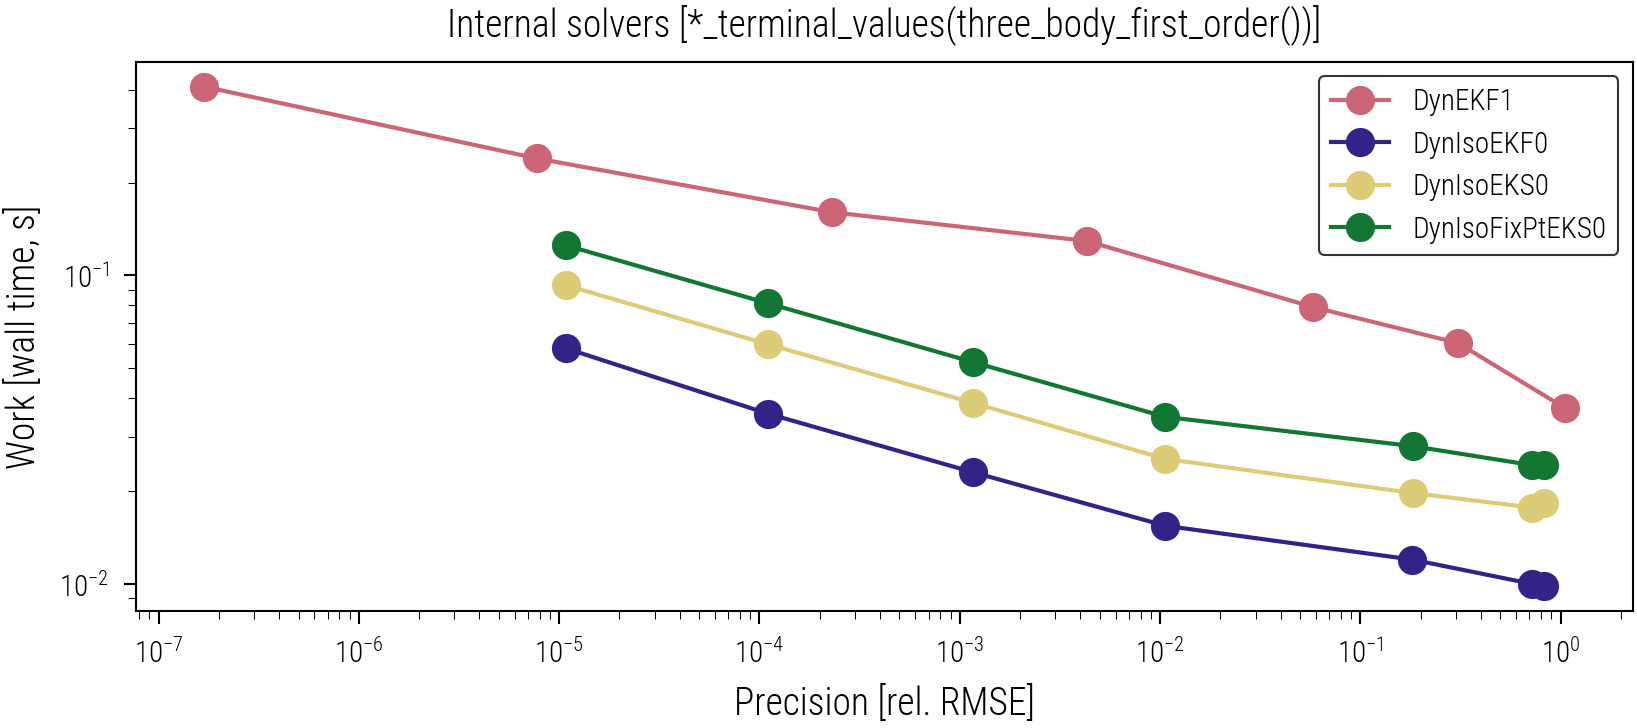

In [5]:
fig, ax = plt.subplots(dpi=300)

for solver in results:
    times, errors = results[solver]
    ax.loglog(errors, times, "o-", label=solver)

ax.set_title("Internal solvers [*_terminal_values(three_body_first_order())]")
ax.set_xlabel("Precision [rel. RMSE]")
ax.set_ylabel("Work [wall time, s]")
ax.legend()
plt.show()

If these results show one thing, then the fact that it is worth building a specialised ODE solver 
for simulate_terminal_values(). The smoothing-based solvers compute extra factors that are just not needed and quite expensive.

It also shows that the extra-work by the EK1, introduced by the need for Jacobians and the lack of a state-space model factorisation, makes the solver strictly more expensive than the isotropic EK0, even on a 4-dimensional problem.


## External solvers
TBD.